# Importing packages

In [1]:
from workers import MasterNode
from models import LinReg, LogReg, LogRegNoncvx, NN_1d_regression
from utils import read_run, get_alg, create_plot_dir, PLOT_PATH
from sklearn.datasets import dump_svmlight_file

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from prep_data import number_of_features
import math
import torch

from numpy.random import default_rng
from numpy import linalg as la
from prep_data import DATASET_PATH
import copy
import sys

# Customizing Matplotlib

In [2]:
plt.style.use('fast')
mpl.rcParams['mathtext.fontset'] = 'cm'
# mpl.rcParams['mathtext.fontset'] = 'dejavusans'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['lines.linewidth'] = 2.0
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['axes.titlesize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['axes.labelsize'] = 'xx-large'

In [3]:
markers = ['x', '.', '+', '1', 'p','*', 'D' , '.',  's']

### Creating artificial dataset

In [4]:
number_of_tasks = 10000
number_of_points_per_task = 20
number_of_points_per_task_validation = 10
dataset_name = '_artificial_sine'
validation_dataset_name = '_artificial_sine_validation'

In [5]:
X_sine = np.empty(shape=(number_of_tasks * number_of_points_per_task, 1))
y_sine = np.empty(shape=(number_of_tasks * number_of_points_per_task))
X_sine_val = np.empty(shape=(number_of_tasks * number_of_points_per_task_validation, 1))
y_sine_val = np.empty(shape=(number_of_tasks * number_of_points_per_task_validation))

In [6]:
rng = default_rng()
a_array = []
b_array = []
for i in range(number_of_tasks):
    a = 0.1 + rng.random() * (5.0 - 0.1)
    a_array.append(a)
    b = rng.random() * 2 * np.pi
    b_array.append(b)
    x_train = -5.0 + rng.random((number_of_points_per_task, 1)) * 10.0
    x_val = -5.0 + rng.random((number_of_points_per_task_validation, 1)) * 10.0
    y_train = a * np.sin(x_train + b)
    y_val = a * np.sin(x_val + b)
    X_sine[number_of_points_per_task * i : number_of_points_per_task * (i + 1)] = x_train.copy()
    y_sine[number_of_points_per_task * i : number_of_points_per_task * (i + 1)] = y_train.squeeze(1).copy()
    X_sine_val[number_of_points_per_task_validation * i : number_of_points_per_task_validation * (i + 1)] = x_val.copy()
    y_sine_val[number_of_points_per_task_validation * i : number_of_points_per_task_validation * (i + 1)] = y_val.squeeze(1).copy()
a_array = np.array(a_array)
b_array = np.array(b_array)

In [7]:
a_array

array([3.07574918, 1.3959319 , 2.54915324, ..., 2.3156357 , 4.74853769,
       4.55951076])

In [8]:
b_array

array([0.09598696, 3.549969  , 3.21034563, ..., 6.11627917, 1.57308739,
       6.15668297])

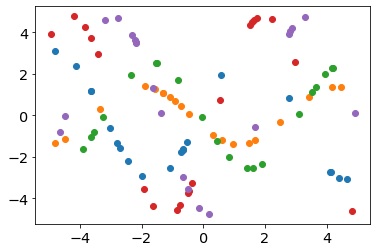

In [16]:
for i in range(min(5, number_of_tasks)):
    inds = range(number_of_points_per_task * i, number_of_points_per_task * (i + 1))
    plt.scatter(X_sine[inds], y_sine[inds])

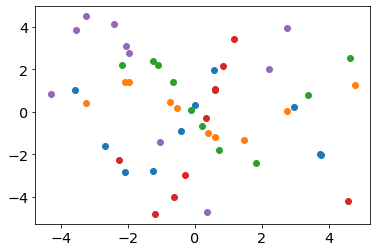

In [15]:
for i in range(min(5, number_of_tasks)):
    inds = range(number_of_points_per_task_validation * i, number_of_points_per_task_validation * (i + 1))
    plt.scatter(X_sine_val[inds], y_sine_val[inds])

In [17]:
# dump_svmlight_file(X_sine, y_sine, DATASET_PATH + dataset_name)
# dump_svmlight_file(X_sine_val, y_sine_val, DATASET_PATH + validation_dataset_name)

In [18]:
# np.save(DATASET_PATH + '_a_tmp.npy', a_array)
# np.save(DATASET_PATH + '_b_tmp.npy', b_array)

In [19]:
a_array = np.load(DATASET_PATH + '_a_tmp.npy')
b_array = np.load(DATASET_PATH + '_b_tmp.npy')

## Explicit Mixture, FOMAML and Reptile trainings

In [20]:
# PLM = pure local model

In [21]:
# parameters
n_workers = number_of_tasks
alpha = 0.5
alg = NN_1d_regression
logreg = False
ordered = True
max_it = 10
compute_smoothness_min = False
tolerance = 1e-2 # not necessary in the experiment
fomaml_inner_loop_lr = 0.01
fomaml_outer_loop_lr = 0.001
gd_stepsize = fomaml_inner_loop_lr
fomaml_number_of_inner_steps = 4
reptile_inner_loop_lr = 0.01
reptile_outer_loop_lr = 0.001
reptile_number_of_inner_steps = 4
modexpmix_inner_loop_lr = 0.01
modexpmix_outer_loop_lr = 0.001
modexpmix_number_of_inner_steps = 4
interm_dim1 = 64
interm_dim2 = 64
validation = True

In [22]:
f = open('model_learning.txt', 'w')
original_stdout = sys.stdout
sys.stdout = f
model = MasterNode(n_workers, 
                   alpha, 
                   alg, 
                   dataset_name, 
                   logreg, 
                   ordered, 
                   max_it, 
                   compute_smoothness_min, 
                   tolerance=tolerance, 
                   fomaml_inner_loop_lr=fomaml_inner_loop_lr,
                   fomaml_outer_loop_lr=fomaml_outer_loop_lr,
                   fomaml_number_of_inner_steps=fomaml_number_of_inner_steps,
                   reptile_inner_loop_lr=reptile_inner_loop_lr,
                   reptile_outer_loop_lr=reptile_outer_loop_lr,
                   reptile_number_of_inner_steps=reptile_number_of_inner_steps,
                   modexpmix_inner_loop_lr=modexpmix_inner_loop_lr,
                   modexpmix_outer_loop_lr=modexpmix_outer_loop_lr,
                   modexpmix_number_of_inner_steps=modexpmix_number_of_inner_steps,
                   gd_stepsiz=gd_stepsize,
                   interm_dim1=interm_dim1,
                   interm_dim2=interm_dim2,
                   validation=validation,
                   validation_dataset_name=validation_dataset_name
                  )
f.close()
sys.stdout = original_stdout

In [ ]:
# W_optimal = np.empty(shape=(number_of_tasks * model.d))
# for i in range(model.n_workers):
#     W_optimal[i * model.d : (i + 1) * model.d] = copy.deepcopy(model.workers[i].w_opt)
# np.save(DATASET_PATH + 'artificial_sine_optimal_models.npy', W_optimal)

In [ ]:
W_optimal = np.load(DATASET_PATH + 'artificial_sine_optimal_models.npy')

In [ ]:
for i in range(model.n_workers):
    model.workers[i].w_opt = W_optimal[i * model.d : (i + 1) * model.d]

In [23]:
number_of_tasks

10000

In [24]:
epochs = 5
task_batch = 10
n_iter = int(epochs * number_of_tasks / task_batch)
data_batch = int(0.7 * number_of_points_per_task)
print('epochs = {}, task_batch = {}, data_batch = {}'.format(epochs, task_batch, data_batch))

epochs = 5, task_batch = 10, data_batch = 14


### Reptile

In [ ]:
f = open('reptile_task_batch{}_epochs{}.txt'.format(task_batch, epochs), 'w')
original_stdout = sys.stdout
sys.stdout = f
reptile_model = model.reptile(epochs=epochs, task_batch=task_batch, data_batch=int(0.7 * (number_of_points_per_task + number_of_points_per_task_validation)))
f.close()
sys.stdout = original_stdout

### FOMAML

In [ ]:
f = open('fomaml_task_batch{}_epochs{}.txt'.format(task_batch, epochs), 'w')
original_stdout = sys.stdout
sys.stdout = f
fomaml_model = model.fomaml(epochs=epochs, task_batch=task_batch, data_batch=data_batch)
f.close()
sys.stdout = original_stdout

### Explicit Mixture

In [ ]:
f = open('sgd_mixed_task_batch{}_epochs{}.txt'.format(task_batch, epochs), 'w')
original_stdout = sys.stdout
sys.stdout = f
explicit_model = model.sgd_mixed(epochs=epochs, task_batch=task_batch)
f.close()
sys.stdout = original_stdout

### Modified Explicit Mixture

In [ ]:
f = open('modified_sgd_mixed_task_batch{}_epochs{}.txt'.format(task_batch, epochs), 'w')
original_stdout = sys.stdout
sys.stdout = f
modified_explicit_mixture = model.sgd_mixed_modified(epochs=epochs, task_batch=task_batch, data_batch=data_batch)
f.close()
sys.stdout = original_stdout

In [216]:
f = open('modified_sgd_mixed_task_batch{}_epochs{}_alphas_varied.txt'.format(task_batch, epochs), 'w')
original_stdout = sys.stdout
sys.stdout = f
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
modified_explicit_mixtures = []
for alpha in alphas:
    model.change_alpha(alpha)
    modified_explicit_mixture = model.sgd_mixed_modified(epochs=epochs, task_batch=task_batch, data_batch=data_batch)
    modified_explicit_mixtures.append(modified_explicit_mixture)
f.close()
sys.stdout = original_stdout

In [217]:
modified_explicit_mixtures = np.array(modified_explicit_mixtures)

### Saved models

In [218]:
# np.save(DATASET_PATH + 'fomaml_sine.npy', fomaml_model)
# np.save(DATASET_PATH + 'reptile_sine.npy', reptile_model)
# np.save(DATASET_PATH + 'explicit_sine.npy', explicit_model)
# np.save(DATASET_PATH + 'explicit_modified_sine.npy', modified_explicit_mixture)
np.save(DATASET_PATH + 'explicit_modified_sine_varied_alphas.npy', modified_explicit_mixtures)

In [ ]:
fomaml_model = np.load(DATASET_PATH + 'fomaml_sine.npy')
reptile_model = np.load(DATASET_PATH + 'reptile_sine.npy')
# explicit_model = np.load(DATASET_PATH + 'explicit_sine.npy')
modified_explicit_mixture = np.load(DATASET_PATH + 'explicit_modified_sine.npy')
modified_explicit_mixtures = np.load(DATASET_PATH + 'explicit_modified_sine_varied_alphas.npy')

## Modified Explicit Mixture, FOMAML and Reptile inference on a new model

In [34]:
rng = default_rng()
a = 0.1 + rng.random() * (5.0 - 0.1)
b = rng.random() * 2 * np.pi
print('a = {}, b = {}'.format(a, b))
x_train = -5.0 + rng.random((number_of_points_per_task, 1)) * 10.0
x_val =  -5.0 + rng.random((number_of_points_per_task_validation, 1)) * 10.0
y_train = a * np.sin(x_train + b)
y_val = a * np.sin(x_val + b)

a = 1.0454990655538425, b = 0.8260535094566075


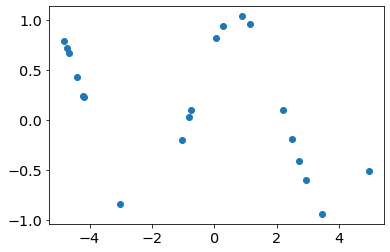

In [35]:
plt.scatter(x_train, y_train)

In [36]:
sine_model = NN_1d_regression(id_node=1000, 
                              alpha=alpha, 
                              x_train=x_train,
                              y_train=y_train,
                              tolerance=1e-2,
                              compute_smoothness_min=False,
                              interm_dim1=interm_dim1,
                              interm_dim2=interm_dim2,
                              validation=True,
                              x_validation=x_val, 
                              y_validation=y_val
                             )

In [37]:
def model_local(model, w, k, inner_loop_lr, batch='full'):
    weights = copy.deepcopy(w) 
    if batch == 'full':
        batch = len(model.x_train)
    generator = default_rng()
    for i in range(k):
        choices = generator.choice(len(model.x_train), size=batch, replace=False)
        x = model.x_train[choices]
        y = model.y_train[choices]
        weights -= inner_loop_lr * model.grad(x, y, weights)
    return weights

In [38]:
def model_local_mixed(model, w_opt_global, k, inner_loop_lr, batch='full'):
    weights = copy.deepcopy(w_opt_global) 
    generator = default_rng()
    if batch == 'full':
        batch = len(model.x_train)
    for i in range(k):
        choices = generator.choice(len(model.x_train), size=batch, replace=False)
        x = model.x_train[choices]
        y = model.y_train[choices]
        weights -= inner_loop_lr * (1.0 - model.alpha) * model.grad(x, y, model.compute_local_modified(weights, w_opt_global))
    return model.compute_local_modified(weights, w_opt_global)

In [39]:
curr_fomaml_model = model_local(model=sine_model, w=fomaml_model, k=10, inner_loop_lr=fomaml_inner_loop_lr)

In [40]:
curr_reptile_model = model_local(model=sine_model, w=reptile_model, k=10, inner_loop_lr=reptile_inner_loop_lr)

In [ ]:
curr_mixture_sf_model = sine_model.compute_local(explicit_model) # explicit straight-forward

In [ ]:
curr_mixture_meta = model_local_mixed(sine_model, w_opt_global=explicit_model, k=10, inner_loop_lr=0.01, batch=int(0.7 * number_of_points_per_task))

In [41]:
curr_modified_mixture = model_local_mixed(sine_model, w_opt_global=modified_explicit_mixture, k=10, inner_loop_lr=0.01)

In [42]:
number_of_test_points = 100

In [43]:
x_test = np.linspace(-5.0, 5.0, number_of_test_points)
y_test = a * np.sin(x_test + b)

In [44]:
x_test = x_test[..., np.newaxis]
y_test = y_test[..., np.newaxis]

In [45]:
sine_model.set_weights(curr_fomaml_model)

In [46]:
y_pred_fomaml = sine_model.model(torch.from_numpy(x_test).float()).detach().numpy()

In [47]:
sine_model.set_weights(curr_reptile_model)

In [48]:
y_pred_reptile = sine_model.model(torch.from_numpy(x_test).float()).detach().numpy()

In [ ]:
sine_model.set_weights(curr_mixture_sf_model)

In [ ]:
y_pred_mixture_sf = sine_model.model(torch.from_numpy(x_test).float()).detach().numpy()

In [ ]:
sine_model.set_weights(curr_mixture_meta)

In [ ]:
y_pred_mixture_meta = sine_model.model(torch.from_numpy(x_test).float()).detach().numpy()

In [49]:
sine_model.set_weights(curr_modified_mixture)

In [50]:
y_pred_modified_mixture = sine_model.model(torch.from_numpy(x_test).float()).detach().numpy()

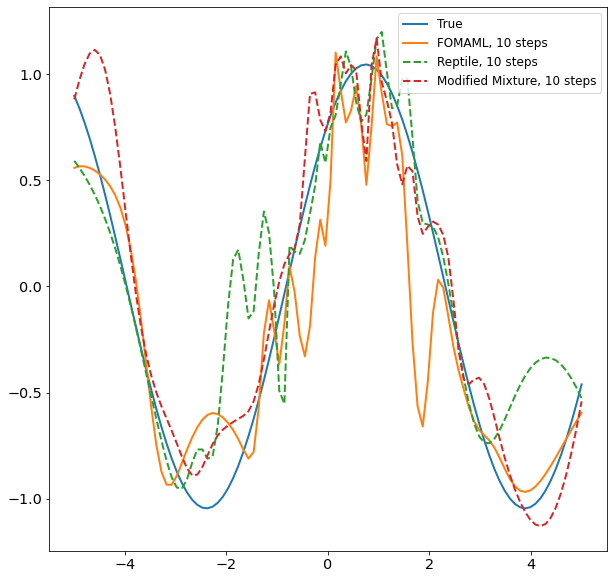

In [51]:
show_every=1
plt.figure(figsize=(10, 10))
plt.plot(x_test, y_test, label='True')
plt.plot(x_test, y_pred_fomaml, ls='-', label='FOMAML, 10 steps')
plt.plot(x_test, y_pred_reptile, ls='--', label='Reptile, 10 steps')
# plt.plot(x_test, y_pred_mixture_sf, ls='--', label='Mixture, straight-forward')
# plt.plot(x_test, y_pred_mixture_meta, ls='--', label='Mixture, 10 steps')
plt.plot(x_test, y_pred_modified_mixture, ls='--', label='Modified Mixture, 10 steps')
plt.legend()
plt.show()

In [52]:
print('FOMAML {}'.format(((y_pred_fomaml - y_test) ** 2).mean()))
print('Reptile {}'.format(((y_pred_reptile - y_test) ** 2).mean()))
print('Modified Mixture {}'.format(((y_pred_modified_mixture - y_test) ** 2).mean()))
# print('Mixture sf {}'.format(((y_pred_exp_mix - y_test) ** 2).mean()))
# print('Mixture 10 steps {}'.format(((y_pred_exp_mix_meta - y_test) ** 2).mean()))

FOMAML 0.09435169576703326
Reptile 0.11677579645225027
Modified Mixture 0.04761636108328279


## Computing generalization properties of the models

In [ ]:
n_test = 1000
number_of_test_points = 200
rng = default_rng()
ks = np.arange(11)
fomaml_res = np.empty(shape=(ks.size, n_test))
reptile_res = np.empty(shape=(ks.size, n_test))
mixture_res = np.empty(shape=(ks.size, n_test))
for test_id in range(n_test):
    a = 0.1 + rng.random() * (5.0 - 0.1)
    b = rng.random() * 2 * np.pi
    x_train = -5.0 + rng.random((number_of_points_per_task, 1)) * 10.0
    x_val =  -5.0 + rng.random((number_of_points_per_task_validation, 1)) * 10.0
    y_train = a * np.sin(x_train + b)
    y_val = a * np.sin(x_val + b)    
    sine_model = NN_1d_regression(id_node=1000, 
                                  alpha=alpha, 
                                  x_train=x_train,
                                  y_train=y_train,
                                  tolerance=1e-2,
                                  compute_smoothness_min=False,
                                  interm_dim1=interm_dim1,
                                  interm_dim2=interm_dim2,
                                  validation=True,
                                  x_validation=x_val, 
                                  y_validation=y_val
                                 )   
    for k in ks:
        curr_fomaml_model = model_local(model=sine_model, w=fomaml_model, k=k, inner_loop_lr=fomaml_inner_loop_lr)
        curr_reptile_model = model_local(model=sine_model, w=reptile_model, k=k, inner_loop_lr=reptile_inner_loop_lr) 
        curr_modified_mixture = model_local_mixed(sine_model, w_opt_global=modified_explicit_mixture, k=k, inner_loop_lr=modexpmix_inner_loop_lr)
        x_test = np.linspace(-5.0, 5.0, number_of_test_points)
        y_test = a * np.sin(x_test + b)
        x_test = x_test[..., np.newaxis]
        y_test = y_test[..., np.newaxis]
        sine_model.set_weights(curr_fomaml_model)
        y_pred_fomaml = sine_model.model(torch.from_numpy(x_test).float()).detach().numpy()
        sine_model.set_weights(curr_reptile_model)
        y_pred_reptile = sine_model.model(torch.from_numpy(x_test).float()).detach().numpy()
        sine_model.set_weights(curr_modified_mixture)
        y_pred_modified_mixture = sine_model.model(torch.from_numpy(x_test).float()).detach().numpy()
        fomaml_res[k, test_id] = ((y_pred_fomaml - y_test) ** 2).mean()
        reptile_res[k, test_id] = ((y_pred_reptile - y_test) ** 2).mean()
        mixture_res[k, test_id] = ((y_pred_modified_mixture - y_test) ** 2).mean()

In [61]:
import seaborn as sns

In [87]:
import pandas as pd

In [138]:
ks_ids = pd.DataFrame(np.repeat(np.array([ks]), repeats=n_test, axis=0).flatten())

main_col_name = 'mean squared error'
pd_fomaml = pd.DataFrame(fomaml_res.flatten(order='F'), columns=[main_col_name])
pd_mix = pd.DataFrame(mixture_res.flatten(order='F'), columns=[main_col_name])
pd_reptile = pd.DataFrame(reptile_res.flatten(order='F'), columns=[main_col_name])

column_name = 'number of gradient steps'
pd_fomaml[column_name] = ks_ids
pd_reptile[column_name] = ks_ids
pd_mix[column_name] = ks_ids

pd_fomaml['model'] = 'FOMAML'
pd_reptile['model'] = 'Reptile'
pd_mix['model'] = 'Modified Mixture'

all_data = pd.concat([pd_fomaml, pd_reptile, pd_mix])

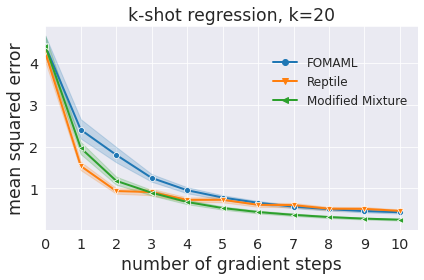

In [212]:
sns.set_style('darkgrid')
g = sns.lineplot(x='number of gradient steps', y='mean squared error', style='model', hue='model', dashes=False, markers=['o', 'v', '<'], data=all_data)
g.set(xlim=(0, None), xticks=ks)
g.legend_.draw_frame(False)
g.legend_.texts[0].set_text('')
g.legend_.texts[3].set_text('Modified Mixture')
g.set_title('k-shot regression, k=20')
plt.tight_layout()
plt.savefig(PLOT_PATH + '/20-shot regression.pdf')

## Comparing Modified Mixture with different alphas

In [ ]:
n_test = 1000
number_of_test_points = 200
rng = default_rng()
ks = np.arange(11)
mixture_res_varied = np.empty(shape=(len(alphas), n_test, ks.size))
for test_id in range(n_test):
    a = 0.1 + rng.random() * (5.0 - 0.1)
    b = rng.random() * 2 * np.pi
    x_train = -5.0 + rng.random((number_of_points_per_task, 1)) * 10.0
    x_val =  -5.0 + rng.random((number_of_points_per_task_validation, 1)) * 10.0
    y_train = a * np.sin(x_train + b)
    y_val = a * np.sin(x_val + b)    
    sine_model = NN_1d_regression(id_node=1000, 
                                  alpha=alpha, 
                                  x_train=x_train,
                                  y_train=y_train,
                                  tolerance=1e-2,
                                  compute_smoothness_min=False,
                                  interm_dim1=interm_dim1,
                                  interm_dim2=interm_dim2,
                                  validation=True,
                                  x_validation=x_val, 
                                  y_validation=y_val
                                 )   
    for k in ks:
        x_test = np.linspace(-5.0, 5.0, number_of_test_points)
        y_test = a * np.sin(x_test + b)
        x_test = x_test[..., np.newaxis]
        y_test = y_test[..., np.newaxis]
        for ind in range(len(alphas)):
            sine_model.change_alpha(alphas[ind])
            curr_modified_mixture = model_local_mixed(sine_model, 
                                                      w_opt_global=modified_explicit_mixtures[ind], 
                                                      k=k, 
                                                      inner_loop_lr=modexpmix_inner_loop_lr)
            sine_model.set_weights(curr_modified_mixture)
            y_pred_modified_mixture = sine_model.model(torch.from_numpy(x_test).float()).detach().numpy()
            mixture_res_varied[ind, test_id, k] = ((y_pred_modified_mixture - y_test) ** 2).mean()

In [269]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [278]:
mixture_res_varied_copy = mixture_res_varied.copy()

In [336]:
np.save(DATASET_PATH + 'mixture_res_varied.npy', mixture_res_varied_copy)

In [313]:
mixture_res_varied = mixture_res_varied_copy.copy()

In [314]:
mixture_res_varied = mixture_res_varied[np.arange(1, 11, 2), :, :]

In [328]:
pd_ks_ids = pd.DataFrame(np.repeat(np.array([ks]), repeats=n_test * len(alphas), axis=0).flatten())
pd_alphas = pd.DataFrame(np.repeat(np.arange(5), repeats = n_test * len(ks)), dtype=int)

main_col_name = 'mean squared error'
all_data = pd.DataFrame(mixture_res_varied.flatten(), columns=[main_col_name])

column_name = 'number of gradient steps'
all_data[column_name] = pd_ks_ids

all_data['model'] = pd_alphas
all_data['model'] = ['${}$'.format(x) for x in all_data['model']]

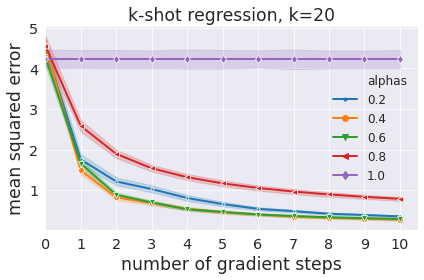

In [335]:
sns.set_style('darkgrid')
g = sns.lineplot(x='number of gradient steps', 
                 y='mean squared error', 
                 style='model', 
                 hue='model',
#                  style_order=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
#                  style_order=np.arange(10),
                 dashes=False,
                 markers = ['.', 'o', 'v', '<', 'd', 'D', 's', 'p', 'P', 'h', 'H'],
                 data=all_data
                )
g.set(xlim=(0, None), xticks=ks)
# g.legend(bbox_to_anchor = (1, 1))
g.legend_.draw_frame(False)
g.legend_.texts[0].set_text('alphas')
g.legend_.texts[1].set_text('0.2')
g.legend_.texts[2].set_text('0.4')
g.legend_.texts[3].set_text('0.6')
g.legend_.texts[4].set_text('0.8')
g.legend_.texts[5].set_text('1.0')
g.set_title('k-shot regression, k=20')
plt.tight_layout()
plt.savefig(PLOT_PATH + '/20-shot regression alphas varied.pdf')

## Sine graph plots

In [106]:
# 1

In [107]:
rng = default_rng()
a = 0.1 + rng.random() * (5.0 - 0.1)
b = rng.random() * 2 * np.pi
print('a = {}, b = {}'.format(a, b))
x_train = -5.0 + rng.random((number_of_points_per_task, 1)) * 10.0
x_val =  -5.0 + rng.random((number_of_points_per_task_validation, 1)) * 10.0
y_train = a * np.sin(x_train + b)
y_val = a * np.sin(x_val + b)

a = 3.6095421948169983, b = 3.233486074473904


In [108]:
sine_model = NN_1d_regression(id_node=1000, 
                              alpha=alpha, 
                              x_train=x_train,
                              y_train=y_train,
                              tolerance=1e-2,
                              compute_smoothness_min=False,
                              interm_dim1=interm_dim1,
                              interm_dim2=interm_dim2,
                              validation=False,
                              x_validation=x_val, 
                              y_validation=y_val
                             )

In [109]:
number_of_test_points = 100

In [110]:
x_test = np.linspace(-5.0, 5.0, number_of_test_points)
y_test = a * np.sin(x_test + b)

In [111]:
x_test = x_test[..., np.newaxis]
y_test = y_test[..., np.newaxis]

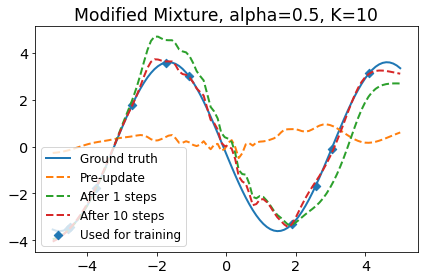

In [122]:
plt.plot(x_test, y_test, label='Ground truth')
plt.scatter(x_train, y_train, marker='D', label='Used for training')
ks = [0, 1, 10]
for k in ks:
    curr_modified_mixture = model_local_mixed(sine_model, w_opt_global=modified_explicit_mixture, k=k, inner_loop_lr=modexpmix_inner_loop_lr)
    sine_model.set_weights(curr_modified_mixture)
    y_pred_modified_mixture = sine_model.model(torch.from_numpy(x_test).float()).detach().numpy()
    if k == 1: 
        label = 'After 1 steps'
    elif k == 0:
        label = 'Pre-update'
    else:
        label = 'After {} steps'.format(k)
    plt.plot(x_test, y_pred_modified_mixture, label=label, ls='--')
plt.legend(loc='lower left')
plt.title('Modified Mixture, alpha=0.5, K=10')
plt.tight_layout()
plt.savefig(PLOT_PATH + '/sine_training_example.pdf')
plt.show()

In [73]:
# 2

In [74]:
a = 0.1 + rng.random() * (5.0 - 0.1)
b = rng.random() * 2 * np.pi
print('a = {}, b = {}'.format(a, b))
x_train = -5.0 + rng.random((number_of_points_per_task, 1)) * 10.0
x_val =  -5.0 + rng.random((number_of_points_per_task_validation, 1)) * 10.0
y_train = a * np.sin(x_train + b)
y_val = a * np.sin(x_val + b)

a = 4.053758039354159, b = 3.229908456661918


In [75]:
sine_model = NN_1d_regression(id_node=1000, 
                              alpha=alpha, 
                              x_train=x_train,
                              y_train=y_train,
                              tolerance=1e-2,
                              compute_smoothness_min=False,
                              interm_dim1=interm_dim1,
                              interm_dim2=interm_dim2,
                              validation=False,
                              x_validation=x_val, 
                              y_validation=y_val
                             )

In [76]:
number_of_test_points = 100

In [77]:
x_test = np.linspace(-5.0, 5.0, number_of_test_points)
y_test = a * np.sin(x_test + b)

In [78]:
x_test = x_test[..., np.newaxis]
y_test = y_test[..., np.newaxis]

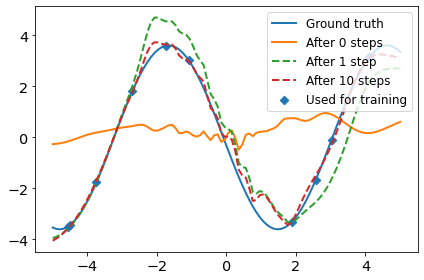

In [118]:
plt.plot(x_test, y_test, label='Ground truth')
plt.scatter(x_train, y_train, marker='D', label='Used for training')
ks = [0, 1, 10]
for k in ks:
    curr_modified_mixture = model_local_mixed(sine_model, w_opt_global=modified_explicit_mixture, k=k, inner_loop_lr=modexpmix_inner_loop_lr)
    sine_model.set_weights(curr_modified_mixture)
    y_pred_modified_mixture = sine_model.model(torch.from_numpy(x_test).float()).detach().numpy()
    if k != 1: 
        label = 'After {} steps'.format(k)
    else:
        label = 'After 1 step' 
    if k == 0:
        ls = '-'
    else:
        ls = '--'
    plt.plot(x_test, y_pred_modified_mixture, label=label, ls=ls)
plt.legend()
plt.tight_layout()
plt.show()

In [80]:
# 3

In [95]:
a = 0.1 + rng.random() * (5.0 - 0.1)
b = rng.random() * 2 * np.pi
print('a = {}, b = {}'.format(a, b))
x_train = -5.0 + rng.random((number_of_points_per_task, 1)) * 10.0
x_val =  -5.0 + rng.random((number_of_points_per_task_validation, 1)) * 10.0
y_train = a * np.sin(x_train + b)
y_val = a * np.sin(x_val + b)

a = 0.5633251572439828, b = 3.8390513078973165


In [96]:
sine_model = NN_1d_regression(id_node=1000, 
                              alpha=alpha, 
                              x_train=x_train,
                              y_train=y_train,
                              tolerance=1e-2,
                              compute_smoothness_min=False,
                              interm_dim1=interm_dim1,
                              interm_dim2=interm_dim2,
                              validation=False,
                              x_validation=x_val, 
                              y_validation=y_val
                             )

In [97]:
number_of_test_points = 100

In [98]:
x_test = np.linspace(-5.0, 5.0, number_of_test_points)
y_test = a * np.sin(x_test + b)

In [99]:
x_test = x_test[..., np.newaxis]
y_test = y_test[..., np.newaxis]

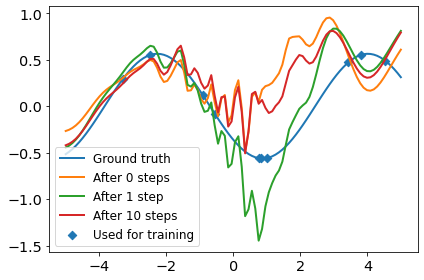

In [102]:
plt.plot(x_test, y_test, label='Ground truth')
plt.scatter(x_train, y_train, marker='D', label='Used for training')
ks = [0, 1, 10]
for k in ks:
    curr_modified_mixture = model_local_mixed(sine_model, w_opt_global=modified_explicit_mixture, k=k, inner_loop_lr=modexpmix_inner_loop_lr)
    sine_model.set_weights(curr_modified_mixture)
    y_pred_modified_mixture = sine_model.model(torch.from_numpy(x_test).float()).detach().numpy()
    if k != 1: 
        label = 'After {} steps'.format(k) 
    else:
        label = 'After 1 step' 
    plt.plot(x_test, y_pred_modified_mixture, label=label)
plt.legend()
plt.tight_layout()
plt.show()